In [1]:
from pathlib import Path

parent_dir = str(Path.cwd().parent)
%cd $parent_dir

/Users/tomtalpir/Random/pyERGM


In [2]:
from pyERGM.utils import *
from pyERGM.ergm import ERGM, ConvergenceTester
from pyERGM.metrics import *

from pyERGM.datasets import sampson_matrix

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import itertools

# Test #1 - Convergence in a perfect sample from an MPLE model

In [3]:
metrics = [NumberOfEdgesDirected(), OutDegree(), InDegree()]

n_nodes = sampson_matrix.shape[0]

mple_model = ERGM(n_nodes, metrics, is_directed=True)
mple_model.fit(sampson_matrix, mple_lr=0.5)

Removing the 0 feature of outdegree to fix multi-collinearity
Removing the 0 feature of indegree to fix multi-collinearity
MPLE with lr 0.5
Logistic regression optimization started
Iteration 0, log-likelihood: -442.1827286887271, time from start: 1.1531304579693824 seconds, lr: 0.5
Iteration 1, log-likelihood: -172.4098979297536, time from start: 1.1593284159898758 seconds, lr: 0.5
Iteration 2, log-likelihood: -166.29645121247756, time from start: 1.168667082907632 seconds, lr: 0.5
Iteration 3, log-likelihood: -164.48422598082374, time from start: 1.1749730829615146 seconds, lr: 0.5
Iteration 4, log-likelihood: -163.93489328866372, time from start: 1.1760204159654677 seconds, lr: 0.5
Iteration 5, log-likelihood: -163.77571342296062, time from start: 1.1824307499919087 seconds, lr: 0.5
Iteration 6, log-likelihood: -163.7318974850064, time from start: 1.1899745829869062 seconds, lr: 0.5
Iteration 7, log-likelihood: -163.72030688606134, time from start: 1.1921376660466194 seconds, lr: 0.5

(None, None)

In [5]:
experiment_results = []

sample_sizes = [200, 1000, 5000, 10000]

n_attempts_per_experiment = 10

hotelling_hyperparams = {
    "confidence": [0.5, 0.95],
    "cov_matrix_estimation_method": ["naive", "batch"],
    "sample_sizes": sample_sizes
}



### Hotelling

In [43]:
hyperparams_keys = list(hotelling_hyperparams.keys())
hyperparams_values = list(hotelling_hyperparams.values())

all_hyperparams = list(itertools.product(*hyperparams_values))
for i, hyperparams in enumerate(all_hyperparams):
    hyperparams = dict(zip(hyperparams_keys, hyperparams))
    print(f"Working on hyperparams {i+1}/{len(all_hyperparams)}")
    print(hyperparams)

    sample_size = hyperparams["sample_sizes"]
    hotelling_confidence = hyperparams["confidence"]
    cov_matrix_estimation_method = hyperparams["cov_matrix_estimation_method"]

    for j in range(n_attempts_per_experiment):
        print(f"\tAttempt: {j+1}/{n_attempts_per_experiment}")
        observed_features = mple_model._metrics_collection.calculate_statistics(sampson_matrix)

        sample_from_mple = mple_model.generate_networks_for_sample(sample_size=sample_size, sampling_method="exact")
        sample_features = mple_model._metrics_collection.calculate_sample_statistics(sample_from_mple)
        mean_features = np.mean(sample_features, axis=1)
        estimated_cov_matrix = covariance_matrix_estimation(sample_features, mean_features, method=cov_matrix_estimation_method)
        inv_estimated_cov_matrix = np.linalg.pinv(estimated_cov_matrix)

        convergence_tester = ConvergenceTester()

        hotelling_result = convergence_tester.hotelling(observed_features, 
                                                        mean_features, 
                                                        inv_estimated_cov_matrix, 
                                                        sample_size, 
                                                        hotelling_confidence)
        
        experiment_results.append({
            "test_type": "Hotelling",
            "sample_size": sample_size,
            "test_statistic": hotelling_result["statistic"],
            "test_critical_value": hotelling_result["threshold"],
            "diff": hotelling_result["statistic"] - hotelling_result["threshold"],
            "success": hotelling_result["success"],
            "confidence": hotelling_confidence,
            "cov_matrix_estimation_method": cov_matrix_estimation_method,
        })



Working on hyperparams 1/16
{'confidence': 0.5, 'cov_matrix_estimation_method': 'naive', 'sample_sizes': 200}
	Attempt: 1/10
	Attempt: 2/10
	Attempt: 3/10
	Attempt: 4/10
	Attempt: 5/10
	Attempt: 6/10
	Attempt: 7/10
	Attempt: 8/10
	Attempt: 9/10
	Attempt: 10/10
Working on hyperparams 2/16
{'confidence': 0.5, 'cov_matrix_estimation_method': 'naive', 'sample_sizes': 1000}
	Attempt: 1/10
	Attempt: 2/10
	Attempt: 3/10
	Attempt: 4/10
	Attempt: 5/10
	Attempt: 6/10
	Attempt: 7/10
	Attempt: 8/10
	Attempt: 9/10
	Attempt: 10/10
Working on hyperparams 3/16
{'confidence': 0.5, 'cov_matrix_estimation_method': 'naive', 'sample_sizes': 5000}
	Attempt: 1/10
	Attempt: 2/10
	Attempt: 3/10
	Attempt: 4/10
	Attempt: 5/10
	Attempt: 6/10
	Attempt: 7/10
	Attempt: 8/10
	Attempt: 9/10
	Attempt: 10/10
Working on hyperparams 4/16
{'confidence': 0.5, 'cov_matrix_estimation_method': 'naive', 'sample_sizes': 10000}
	Attempt: 1/10
	Attempt: 2/10
	Attempt: 3/10
	Attempt: 4/10
	Attempt: 5/10
	Attempt: 6/10
	Attempt: 7/1

In [49]:
df

,test_type,sample_size,test_statistic,test_critical_value,diff,success,confidence,cov_matrix_estimation_method
0,Hotelling,200,1.413568,0.985000,0.428568,False,0.50,naive
1,Hotelling,200,1.344284,0.985000,0.359284,False,0.50,naive
2,Hotelling,200,0.802246,0.985000,-0.182753,True,0.50,naive
3,Hotelling,200,0.827924,0.985000,-0.157075,True,0.50,naive
4,Hotelling,200,1.214586,0.985000,0.229586,False,0.50,naive
...,...,...,...,...,...,...,...,...
155,Hotelling,10000,1.195497,0.641519,0.553978,False,0.95,batch
156,Hotelling,10000,1.502025,0.641519,0.860506,False,0.95,batch
157,Hotelling,10000,1.328387,0.641519,0.686868,False,0.95,batch
158,Hotelling,10000,1.361425,0.641519,0.719907,False,0.95,batch


<Axes: >

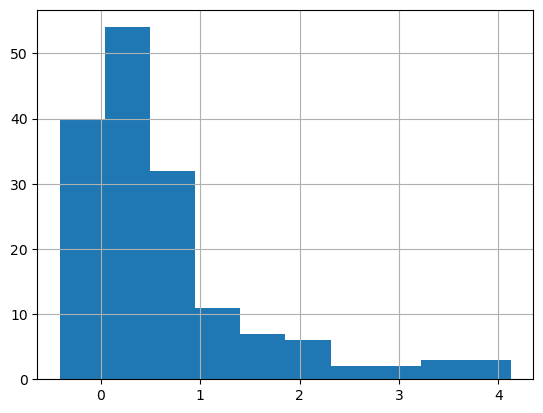

In [53]:
df["diff"].hist()

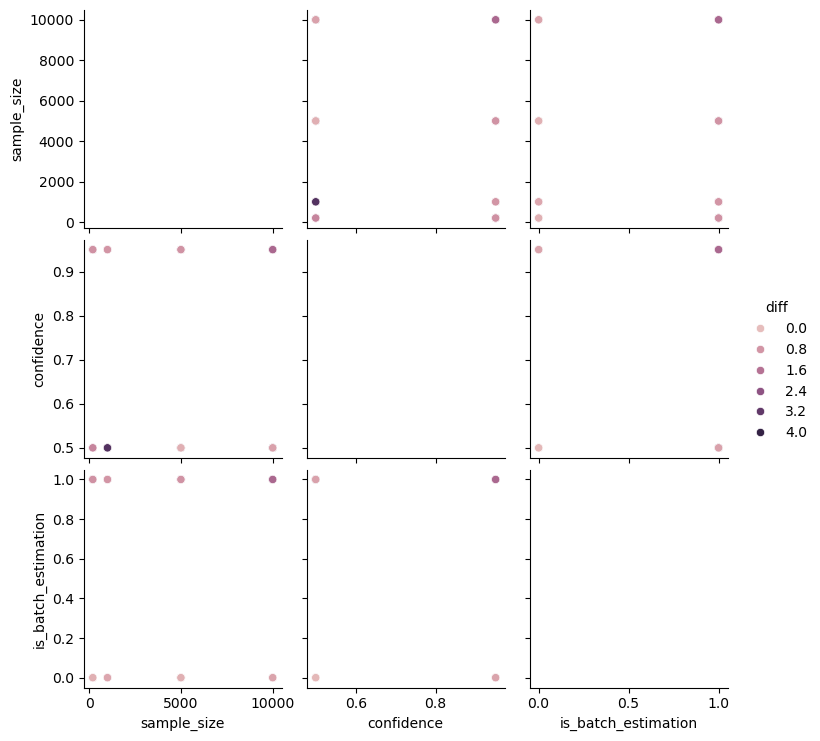

In [55]:
df = pd.DataFrame(experiment_results)
df["is_batch_estimation"] = df["cov_matrix_estimation_method"] == "batch"

sns.pairplot(
    df,
    x_vars=["sample_size", "confidence", "is_batch_estimation"],
    y_vars=["sample_size", "confidence", "is_batch_estimation"],
    hue="diff",
)

In [ ]:
z

In [27]:
hotelling_confidence = 0.95
sample_sizes = [200, 500, 1000, 5000, 10000]
# sample_sizes = [5000]
n_attempts = 10
for sample_size in sample_sizes:
    for i in range(n_attempts):
        print(f"Sample size: {sample_size}, Attempt: {i+1}/{n_attempts}")
        observed_features = mple_model._metrics_collection.calculate_statistics(sampson_matrix)

        sample_from_mple = mple_model.generate_networks_for_sample(sample_size=sample_size, sampling_method="exact")
        sample_features = mple_model._metrics_collection.calculate_sample_statistics(sample_from_mple)
        mean_features = np.mean(sample_features, axis=1)
        estimated_cov_matrix = covariance_matrix_estimation(sample_features, mean_features, method="naive")
        inv_estimated_cov_matrix = np.linalg.pinv(estimated_cov_matrix)

        convergence_tester = ConvergenceTester()

        hotelling_result = convergence_tester.hotelling(observed_features, 
                                                        mean_features, 
                                                        inv_estimated_cov_matrix, 
                                                        sample_size, 
                                                        hotelling_confidence)
        
        experiment_results.append({
            "test_type": "Hotelling",
            "sample_size": sample_size,
            "test_statistic": hotelling_result["statistic"],
            "test_critical_value": hotelling_result["threshold"],
            "diff": hotelling_result["statistic"] - hotelling_result["threshold"],
            "success": hotelling_result["success"],
            "confidence": hotelling_confidence,
            "cov_matrix_estimation_method": "naive",
        })




Sample size: 200, Attempt: 1/10
Sample size: 200, Attempt: 2/10
Sample size: 200, Attempt: 3/10
Sample size: 200, Attempt: 4/10
Sample size: 200, Attempt: 5/10
Sample size: 200, Attempt: 6/10
Sample size: 200, Attempt: 7/10
Sample size: 200, Attempt: 8/10
Sample size: 200, Attempt: 9/10
Sample size: 200, Attempt: 10/10
Sample size: 500, Attempt: 1/10
Sample size: 500, Attempt: 2/10
Sample size: 500, Attempt: 3/10
Sample size: 500, Attempt: 4/10
Sample size: 500, Attempt: 5/10
Sample size: 500, Attempt: 6/10
Sample size: 500, Attempt: 7/10
Sample size: 500, Attempt: 8/10
Sample size: 500, Attempt: 9/10
Sample size: 500, Attempt: 10/10
Sample size: 1000, Attempt: 1/10
Sample size: 1000, Attempt: 2/10
Sample size: 1000, Attempt: 3/10
Sample size: 1000, Attempt: 4/10
Sample size: 1000, Attempt: 5/10
Sample size: 1000, Attempt: 6/10
Sample size: 1000, Attempt: 7/10
Sample size: 1000, Attempt: 8/10
Sample size: 1000, Attempt: 9/10
Sample size: 1000, Attempt: 10/10
Sample size: 5000, Attempt:

In [18]:
hotelling_confidence = 0.5
sample_sizes = [200, 500, 1000, 5000, 10000]
# sample_sizes = [5000]
n_attempts = 10
for sample_size in sample_sizes:
    for i in range(n_attempts):
        print(f"Sample size: {sample_size}, Attempt: {i+1}/{n_attempts}")
        observed_features = mple_model._metrics_collection.calculate_statistics(sampson_matrix)

        sample_from_mple = mple_model.generate_networks_for_sample(sample_size=sample_size, sampling_method="exact")
        sample_features = mple_model._metrics_collection.calculate_sample_statistics(sample_from_mple)
        mean_features = np.mean(sample_features, axis=1)
        estimated_cov_matrix = covariance_matrix_estimation(sample_features, mean_features, method="naive")
        inv_estimated_cov_matrix = np.linalg.pinv(estimated_cov_matrix)

        convergence_tester = ConvergenceTester()

        hotelling_result = convergence_tester.hotelling(observed_features, 
                                                        mean_features, 
                                                        inv_estimated_cov_matrix, 
                                                        sample_size, 
                                                        hotelling_confidence)
        
        experiment_results.append({
            "test_type": "Hotelling",
            "sample_size": sample_size,
            "test_statistic": hotelling_result["statistic"],
            "test_critical_value": hotelling_result["threshold"],
            "diff": hotelling_result["statistic"] - hotelling_result["threshold"],
            "success": hotelling_result["success"],
            "confidence": hotelling_confidence
        })



Sample size: 200, Attempt: 1/10
Sample size: 200, Attempt: 2/10
Sample size: 200, Attempt: 3/10
Sample size: 200, Attempt: 4/10
Sample size: 200, Attempt: 5/10
Sample size: 200, Attempt: 6/10
Sample size: 200, Attempt: 7/10
Sample size: 200, Attempt: 8/10
Sample size: 200, Attempt: 9/10
Sample size: 200, Attempt: 10/10
Sample size: 500, Attempt: 1/10
Sample size: 500, Attempt: 2/10
Sample size: 500, Attempt: 3/10
Sample size: 500, Attempt: 4/10
Sample size: 500, Attempt: 5/10
Sample size: 500, Attempt: 6/10
Sample size: 500, Attempt: 7/10
Sample size: 500, Attempt: 8/10
Sample size: 500, Attempt: 9/10
Sample size: 500, Attempt: 10/10
Sample size: 1000, Attempt: 1/10
Sample size: 1000, Attempt: 2/10
Sample size: 1000, Attempt: 3/10
Sample size: 1000, Attempt: 4/10
Sample size: 1000, Attempt: 5/10
Sample size: 1000, Attempt: 6/10
Sample size: 1000, Attempt: 7/10
Sample size: 1000, Attempt: 8/10
Sample size: 1000, Attempt: 9/10
Sample size: 1000, Attempt: 10/10
Sample size: 5000, Attempt:

#### Network split augmentation

In [19]:
sample_sizes = [200, 500, 1000, 5000, 10000]
n_attempts = 10
# sample_sizes = [5000]
# n_attempts = 1

num_subsamples_from_observed = 1000 # Try also for [10, 100, 1k, 10k]
data_splitting_method = "uniform"

split_augmentation_features = mple_model._metrics_collection.bootstrap_observed_features(sampson_matrix,
                                                                num_subsamples=num_subsamples_from_observed,
                                                                splitting_method=data_splitting_method)
split_augment_observed_covariance = covariance_matrix_estimation(split_augmentation_features,
                                    split_augmentation_features.mean(axis=1), method='naive')
inv_split_augment_observed_covariance = np.linalg.inv(split_augment_observed_covariance)

num_subsamples = 100
subsample_size = 1000
confidence = 0.95
stds_away_thr = 1

for sample_size in sample_sizes:
    for i in range(n_attempts):
        print(f"Sample size: {sample_size}, Attempt: {i+1}/{n_attempts}")
        observed_features = mple_model._metrics_collection.calculate_statistics(sampson_matrix)

        sample_from_mple = mple_model.generate_networks_for_sample(sample_size=sample_size, sampling_method="exact")
        convergence_tester = ConvergenceTester()
    
        split_augmentation_result = convergence_tester.bootstrapped_mahalanobis_from_observed(
                    observed_features,
                    sample_from_mple,
                    mple_model._metrics_collection,
                    inv_split_augment_observed_covariance,
                    num_subsamples=num_subsamples,
                    subsample_size=subsample_size,
                    confidence=confidence,
                    stds_away_thr=stds_away_thr,
                )
        
        experiment_results.append({
            "sample_size": sample_size,
            "test_statistic": split_augmentation_result["statistic"],
            "test_critical_value": split_augmentation_result["threshold"],
            "diff": split_augmentation_result["statistic"] - split_augmentation_result["threshold"],
            "success": split_augmentation_result["success"],
            "test_type": "Split Augmentation with Bootstrapped Mahalanobis From Observed",
            "num_subsamples": num_subsamples,
            "subsample_size": subsample_size,
            "confidence": confidence,
            "stds_away_thr": stds_away_thr
        })



Sample size: 200, Attempt: 1/10
Sample size: 200, Attempt: 2/10
Sample size: 200, Attempt: 3/10
Sample size: 200, Attempt: 4/10
Sample size: 200, Attempt: 5/10
Sample size: 200, Attempt: 6/10
Sample size: 200, Attempt: 7/10
Sample size: 200, Attempt: 8/10
Sample size: 200, Attempt: 9/10
Sample size: 200, Attempt: 10/10
Sample size: 500, Attempt: 1/10
Sample size: 500, Attempt: 2/10
Sample size: 500, Attempt: 3/10
Sample size: 500, Attempt: 4/10
Sample size: 500, Attempt: 5/10
Sample size: 500, Attempt: 6/10
Sample size: 500, Attempt: 7/10
Sample size: 500, Attempt: 8/10
Sample size: 500, Attempt: 9/10
Sample size: 500, Attempt: 10/10
Sample size: 1000, Attempt: 1/10
Sample size: 1000, Attempt: 2/10
Sample size: 1000, Attempt: 3/10
Sample size: 1000, Attempt: 4/10
Sample size: 1000, Attempt: 5/10
Sample size: 1000, Attempt: 6/10
Sample size: 1000, Attempt: 7/10
Sample size: 1000, Attempt: 8/10
Sample size: 1000, Attempt: 9/10
Sample size: 1000, Attempt: 10/10
Sample size: 5000, Attempt:

### Bootstrapped mahalanobis from model

In [17]:
# bootstrapped_mahalanobis_from_model
experiment_results = []
sample_sizes = [200, 500, 1000, 5000]
n_attempts = 5
# sample_sizes = [5000]

# one_edge_neighbors_features = mple_model._metrics_collection.get_1_edge_neighboring_features(sampson_matrix)
# one_edge_neighbors_observed_covariance = covariance_matrix_estimation(one_edge_neighbors_features,
#                                     one_edge_neighbors_features.mean(axis=1), method='naive')
# inv_one_edge_neighbors_observed_covariance = np.linalg.inv(one_edge_neighbors_observed_covariance)

num_subsamples = 100
subsample_size = 1000
confidence = 0.95
stds_away_thr = 1

observed_features = mple_model._metrics_collection.calculate_statistics(sampson_matrix)

for sample_size in sample_sizes:
    for i in range(n_attempts):
        print(f"Sample size: {sample_size}, Attempt: {i+1}/{n_attempts}")
        

        # sample_from_mple = mple_model.generate_networks_for_sample(sample_size=sample_size, sampling_method="exact")
        # seed_network = mple_model.generate_networks_for_sample(sample_size=1, sampling_method="exact")[:, :, 0]
        # sample_from_mple = mple_model.generate_networks_for_sample(sample_size=sample_size, sampling_method="metropolis_hastings", burn_in=0, seed_network=seed_network, mcmc_steps_per_sample=sampson_matrix.shape[0]**2)

        sample_from_mple = mple_model.generate_networks_for_sample(sample_size=sample_size, sampling_method="metropolis_hastings", burn_in=0, mcmc_steps_per_sample=sampson_matrix.shape[0]**2)

        convergence_tester = ConvergenceTester()
    
        mahalanobis_from_model_test = convergence_tester.bootstrapped_mahalanobis_from_model(
                    observed_features,
                    sample_from_mple,
                    mple_model._metrics_collection,
                    num_subsamples=num_subsamples,
                    subsample_size=subsample_size,
                    confidence=confidence,
                    stds_away_thr=stds_away_thr,
                )
        
        experiment_results.append({
            "sample_size": sample_size,
            "test_statistic": mahalanobis_from_model_test["statistic"],
            "test_critical_value": mahalanobis_from_model_test["threshold"],
            "diff": mahalanobis_from_model_test["statistic"] - mahalanobis_from_model_test["threshold"],
            "success": mahalanobis_from_model_test["success"],
            "test_type": "Bootstrapped mahalanobis from model",
            "num_subsamples": num_subsamples,
            "subsample_size": subsample_size,
            "confidence": confidence,
            "stds_away_thr": stds_away_thr
        })



Sample size: 200, Attempt: 1/5
Sampled 100/200 networks, time taken: 0.40571022033691406
Sampled 200/200 networks, time taken: 0.8103659152984619
Sample size: 200, Attempt: 2/5
Sampled 100/200 networks, time taken: 0.37406110763549805
Sampled 200/200 networks, time taken: 0.7745420932769775
Sample size: 200, Attempt: 3/5
Sampled 100/200 networks, time taken: 0.4091928005218506
Sampled 200/200 networks, time taken: 0.791395902633667
Sample size: 200, Attempt: 4/5
Sampled 100/200 networks, time taken: 0.39715003967285156
Sampled 200/200 networks, time taken: 0.7863938808441162
Sample size: 200, Attempt: 5/5
Sampled 100/200 networks, time taken: 0.3864266872406006
Sampled 200/200 networks, time taken: 0.7885088920593262
Sample size: 500, Attempt: 1/5
Sampled 100/500 networks, time taken: 0.3980979919433594
Sampled 200/500 networks, time taken: 0.7904400825500488
Sampled 300/500 networks, time taken: 1.1814930438995361
Sampled 400/500 networks, time taken: 1.5820369720458984
Sampled 500/50

In [43]:


experiment_with_noisy_sample = []
sample_sizes = [200, 500, 1000, 5000]
n_attempts = 1
# sample_sizes = [5000]

# one_edge_neighbors_features = mple_model._metrics_collection.get_1_edge_neighboring_features(sampson_matrix)
# one_edge_neighbors_observed_covariance = covariance_matrix_estimation(one_edge_neighbors_features,
#                                     one_edge_neighbors_features.mean(axis=1), method='naive')
# inv_one_edge_neighbors_observed_covariance = np.linalg.inv(one_edge_neighbors_observed_covariance)

num_subsamples = 100
subsample_size = 1000
confidence = 0.95
stds_away_thr = 1

observed_features = mple_model._metrics_collection.calculate_statistics(sampson_matrix)


for sample_size in sample_sizes:
    for i in range(n_attempts):
        v1 = np.random.rand(observed_features.shape[0])
        v1 /= np.linalg.norm(v1)

        noise_observed_features = observed_features + 5 * v1

        
        print(f"Sample size: {sample_size}, Attempt: {i+1}/{n_attempts}")
        

        # sample_from_mple = mple_model.generate_networks_for_sample(sample_size=sample_size, sampling_method="exact")
        # seed_network = mple_model.generate_networks_for_sample(sample_size=1, sampling_method="exact")[:, :, 0]
        # sample_from_mple = mple_model.generate_networks_for_sample(sample_size=sample_size, sampling_method="metropolis_hastings", burn_in=0, seed_network=seed_network, mcmc_steps_per_sample=sampson_matrix.shape[0]**2)

        # sample_from_mple = mple_model.generate_networks_for_sample(sample_size=sample_size, sampling_method="metropolis_hastings", burn_in=0, mcmc_steps_per_sample=sampson_matrix.shape[0]**2)
        sampled_features_from_noise = np.random.multivariate_normal(noise_observed_features, np.eye(observed_features.shape[0]), size=sample_size).T

        # sample_size = sampled_networks.shape[2]
        num_of_features = observed_features.shape[0]

        mahalanobis_dists = np.zeros(num_subsamples)

        sub_sample_indices = np.random.choice(np.arange(sample_size), size=num_subsamples * subsample_size)
        sub_samples = sampled_features_from_noise[:, sub_sample_indices]
        # sub_samples_features = metrics_collection.calculate_sample_statistics(sub_samples)
        sub_samples_features = sampled_features_from_noise.reshape(num_of_features, num_subsamples, subsample_size)

        # for cur_subsam_idx in range(num_subsamples):
        #     sub_sample = sub_samples_features[:, cur_subsam_idx, :]
        #     sub_sample_mean = sub_sample.mean(axis=1)
        #     model_covariance_matrix = covariance_matrix_estimation(sub_sample, sub_sample_mean, method="naive")
        #     inv_model_cov_matrix = np.linalg.pinv(model_covariance_matrix)
        #     mahalanobis_dists[cur_subsam_idx] = mahalanobis(observed_features, sub_sample_mean, inv_model_cov_matrix)
        
        # empirical_threshold = np.quantile(mahalanobis_dists, confidence)

        # return {
        #     "success": empirical_threshold < stds_away_thr,
        #     "statistic": empirical_threshold,
        #     "threshold": stds_away_thr
        # }

        # convergence_tester = ConvergenceTester()
    
        # mahalanobis_from_model_test = convergence_tester.bootstrapped_mahalanobis_from_model(
        #             observed_features,
        #             sample_from_noise,
        #             mple_model._metrics_collection,
        #             num_subsamples=num_subsamples,
        #             subsample_size=subsample_size,
        #             confidence=confidence,
        #             stds_away_thr=stds_away_thr,
        #         )
        
        # experiment_with_noisy_sample.append({
        #     "sample_size": sample_size,
        #     "test_statistic": mahalanobis_from_model_test["statistic"],
        #     "test_critical_value": mahalanobis_from_model_test["threshold"],
        #     "diff": mahalanobis_from_model_test["statistic"] - mahalanobis_from_model_test["threshold"],
        #     "success": mahalanobis_from_model_test["success"],
        #     "test_type": "Bootstrapped mahalanobis from model",
        #     "num_subsamples": num_subsamples,
        #     "subsample_size": subsample_size,
        #     "confidence": confidence,
        #     "stds_away_thr": stds_away_thr
        # })



Sample size: 200, Attempt: 1/1


ValueError: cannot reshape array of size 7000 into shape (35,100,1000)

In [47]:
sampled_features_from_noise.T.reshape(num_of_features, num_subsamples, subsample_size)

ValueError: cannot reshape array of size 7000 into shape (35,100,1000)

<Axes: xlabel='sample_size', ylabel='diff'>

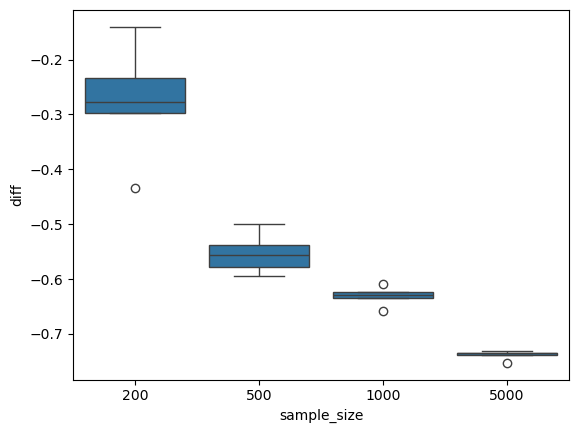

In [18]:
experiments_df = pd.DataFrame(experiment_results)
sns.boxplot(
    x="sample_size", 
    y="diff", 
    data=experiments_df, 
)

In [14]:
experiments_df_with_burnin_and_1k_mcmc_steps = experiments_df.copy()

<Axes: xlabel='sample_size', ylabel='diff'>

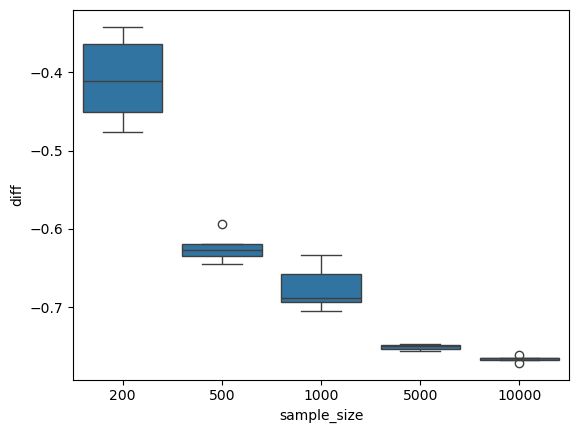

In [10]:
experiments_df = pd.DataFrame(experiment_results)
sns.boxplot(
    x="sample_size", 
    y="diff", 
    data=experiments_df, 
)

In [8]:
experiments_df

,sample_size,test_statistic,test_critical_value,diff,success,test_type,num_subsamples,subsample_size,confidence,stds_away_thr
0,5000,0.252148,1,-0.747852,True,Bootstrapped mahalanobis from model,100,1000,0.95,1
1,5000,0.243788,1,-0.756212,True,Bootstrapped mahalanobis from model,100,1000,0.95,1
2,5000,0.251201,1,-0.748799,True,Bootstrapped mahalanobis from model,100,1000,0.95,1
3,5000,0.248563,1,-0.751437,True,Bootstrapped mahalanobis from model,100,1000,0.95,1
4,5000,0.253419,1,-0.746581,True,Bootstrapped mahalanobis from model,100,1000,0.95,1


### 1-edge noisy neighborhood

In [20]:
sample_sizes = [200, 500, 1000, 5000, 10000]
n_attempts = 10
# sample_sizes = [5000]

one_edge_neighbors_features = mple_model._metrics_collection.get_1_edge_neighboring_features(sampson_matrix)
one_edge_neighbors_observed_covariance = covariance_matrix_estimation(one_edge_neighbors_features,
                                    one_edge_neighbors_features.mean(axis=1), method='naive')
inv_one_edge_neighbors_observed_covariance = np.linalg.inv(one_edge_neighbors_observed_covariance)

num_subsamples = 100
subsample_size = 1000
confidence = 0.95
stds_away_thr = 1

for sample_size in sample_sizes:
    for i in range(n_attempts):
        print(f"Sample size: {sample_size}, Attempt: {i+1}/{n_attempts}")
        observed_features = mple_model._metrics_collection.calculate_statistics(sampson_matrix)

        sample_from_mple = mple_model.generate_networks_for_sample(sample_size=sample_size, sampling_method="exact")
        convergence_tester = ConvergenceTester()
    
        one_edge_neighbors_result = convergence_tester.bootstrapped_mahalanobis_from_observed(
                    observed_features,
                    sample_from_mple,
                    mple_model._metrics_collection,
                    inv_one_edge_neighbors_observed_covariance,
                    num_subsamples=num_subsamples,
                    subsample_size=subsample_size,
                    confidence=confidence,
                    stds_away_thr=stds_away_thr,
                )
        
        experiment_results.append({
            "sample_size": sample_size,
            "test_statistic": one_edge_neighbors_result["statistic"],
            "test_critical_value": one_edge_neighbors_result["threshold"],
            "diff": one_edge_neighbors_result["statistic"] - one_edge_neighbors_result["threshold"],
            "success": one_edge_neighbors_result["success"],
            "test_type": "1-edge neighbors with Bootstrapped Mahalanobis From Observed",
            "num_subsamples": num_subsamples,
            "subsample_size": subsample_size,
            "confidence": confidence,
            "stds_away_thr": stds_away_thr
        })



Sample size: 200, Attempt: 1/10
Sample size: 200, Attempt: 2/10
Sample size: 200, Attempt: 3/10
Sample size: 200, Attempt: 4/10
Sample size: 200, Attempt: 5/10
Sample size: 200, Attempt: 6/10
Sample size: 200, Attempt: 7/10
Sample size: 200, Attempt: 8/10
Sample size: 200, Attempt: 9/10
Sample size: 200, Attempt: 10/10
Sample size: 500, Attempt: 1/10
Sample size: 500, Attempt: 2/10
Sample size: 500, Attempt: 3/10
Sample size: 500, Attempt: 4/10
Sample size: 500, Attempt: 5/10
Sample size: 500, Attempt: 6/10
Sample size: 500, Attempt: 7/10
Sample size: 500, Attempt: 8/10
Sample size: 500, Attempt: 9/10
Sample size: 500, Attempt: 10/10
Sample size: 1000, Attempt: 1/10
Sample size: 1000, Attempt: 2/10
Sample size: 1000, Attempt: 3/10
Sample size: 1000, Attempt: 4/10
Sample size: 1000, Attempt: 5/10
Sample size: 1000, Attempt: 6/10
Sample size: 1000, Attempt: 7/10
Sample size: 1000, Attempt: 8/10
Sample size: 1000, Attempt: 9/10
Sample size: 1000, Attempt: 10/10
Sample size: 5000, Attempt:

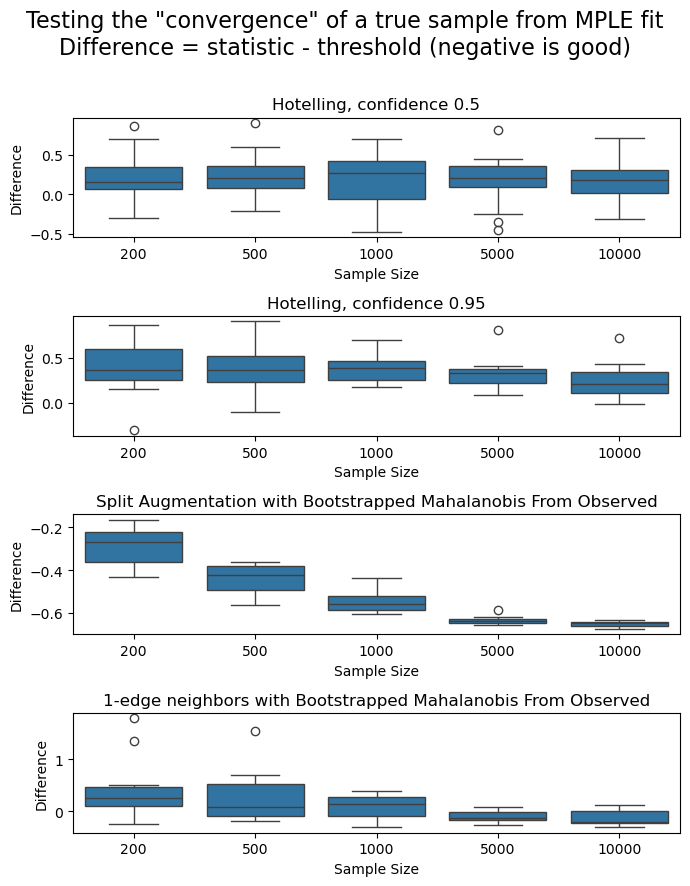

In [33]:
experiments_df = pd.DataFrame(experiment_results)

fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(7, 9))

hotelling_df = experiments_df[experiments_df["test_type"] == "Hotelling"]
split_augmentation_df = experiments_df[experiments_df["test_type"] == "Split Augmentation with Bootstrapped Mahalanobis From Observed"]
one_edge_df = experiments_df[experiments_df["test_type"] == "1-edge neighbors with Bootstrapped Mahalanobis From Observed"]
hotelling_df_95 = experiments_df[(experiments_df["test_type"] == "Hotelling") & (experiments_df["confidence"] == 0.95)]

sns.boxplot(
    x="sample_size", 
    y="diff", 
    data=hotelling_df, 
    ax=ax[0])

sns.boxplot(
    x="sample_size", 
    y="diff", 
    data=hotelling_df_95, 
    ax=ax[1])

sns.boxplot(
    x="sample_size", 
    y="diff", 
    data=split_augmentation_df, 
    ax=ax[2])

sns.boxplot(
    x="sample_size", 
    y="diff", 
    data=one_edge_df, 
    ax=ax[3])

ax[0].set_title(f"Hotelling, confidence 0.5")
ax[1].set_title(f"Hotelling, confidence 0.95")
ax[2].set_title("Split Augmentation with Bootstrapped Mahalanobis From Observed")
ax[3].set_title("1-edge neighbors with Bootstrapped Mahalanobis From Observed")

ax[0].set_xlabel("Sample Size")
ax[1].set_xlabel("Sample Size")
ax[2].set_xlabel("Sample Size")
ax[3].set_xlabel("Sample Size")

ax[0].set_ylabel("Difference")
ax[1].set_ylabel("Difference")
ax[2].set_ylabel("Difference")
ax[3].set_ylabel("Difference")


suptitle = """Testing the "convergence" of a true sample from MPLE fit
Difference = statistic - threshold (negative is good)
"""

fig.suptitle(suptitle, fontsize=16)

plt.tight_layout()
plt.show()